# Using Web Server Logs to Answer Product and Business Questions 
## Redpanda + Bytewax + DuckDB

Back when I worked at GitHub, we pulled many of our metrics out of a data source we called requests. This was an accumulation of all (or nearly all) of the HTTP requests across the GitHub products. The data originated from logs generated from web servers or in some cases from a load balancer. This data allowed us to determine things like who is using which parts of the product and how they are using the product. It turns out this is a more common source of data than just GitHub. Companies often lack perfect telemetry for their products and in order to get information on what is happening, we can look to the server log data.

Most often, the raison d'etre of a data team is to facilitate answers to questions like we had at GitHub. Who is using the product and how are they using it. The root capability required to answer question like we at GitHub had, is the ability to count things reliably and at scale.

![quote: the ability to count things reliably and at scale](img/quote.png)

What I am going to demonstrate in this tutorial is how you can set up a relatively lightweight data stack that will serve as a platform to answer questions from web server access logs about who is using your product and how they are using it. This Data Stack can run on any cloud, could scale with your business and potentially provide all the capabilities you require, this ain't no toy data stack.

The data stack used here as is summarized in the diagram below uses [Redpanda](https://redpanda.com/), [Bytewax](https://www.bytewax.io/) and [DuckDB](https://duckdb.org/). Redpanda serves as the streaming platform, Bytewax as the processing substrate for EL and some T and then duckDB as a serverless query engine for exploration.

---------

For this tutorial we are using web server access logs sourced from Kaggle and we have sampled the first 1000. You can find the full log file [here](https://www.kaggle.com/datasets/eliasdabbas/web-server-access-logs?resource=download). To start, we are going to run a Redpanda cluster, create a topic and load it with the log data. Then, we will write a dataflow that will parse the logs and store them in s3 (we will actually mock this part with local storage instead). Then we will show you how you can use duckDB to query them.

## Redpanda

For your production use case, it is recommended that you run Redpanda directly on the machine/vm and not in docker, for this tutorial we are going to run our Redpanda cluster in a docker container for simplicity and easy setup/teardown. Refer to the [Redpanda Documentation](https://docs.redpanda.com/docs/home/) for more in-depth setup and configuration details.

```bash
docker run -d --pull=always --name=redpanda-1 --rm \
-p 8081:8081 \
-p 8082:8082 \
-p 9092:9092 \
-p 9644:9644 \
docker.redpanda.com/vectorized/redpanda:latest \
redpanda start \
--overprovisioned \
--smp 1  \
--memory 1G \
--reserve-memory 0M \
--node-id 0 \
--check=false
```

Now that we have our streaming platform set up, let's take a quick look at what the server logs look like before diving into the dataflow code below. 

In [2]:
!head input_data/first1000.log

/Users/awmatheson/.zshenv:source:1: no such file or directory: /Users/awmatheson/.cargo/env
54.36.149.41 - - [22/Jan/2019:03:56:14 +0330] "GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C%DA%A9%D8%B3%D9%84,27|%DA%A9%D9%85%D8%AA%D8%B1%20%D8%A7%D8%B2%205%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C%DA%A9%D8%B3%D9%84,p53 HTTP/1.1" 200 30577 "-" "Mozilla/5.0 (compatible; AhrefsBot/6.1; +http://ahrefs.com/robot/)" "-"
31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] "GET /image/60844/productModel/200x200 HTTP/1.1" 200 5667 "https://www.zanbil.ir/m/filter/b113" "Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36" "-"
31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] "GET /image/61474/productModel/200x200 HTTP/1.1" 200 5379 "https://www.zanbil.ir/m/filter/b113" "Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36" "-"
40.77.167.129

These look pretty standard. We have the IP address, the GET request, referrer, user agent, status code and more. We can probably get some pretty interesting answers from this data like where requests are made from and by who. In the dataflow we will seek to convert these log lines into something useable.

Our dataflow will take the raw logs as an input from Redpanda, enrich them, parse them, and then write them to a file store in a columnar format (parquet). We are doing some minor enrichment directly in the dataflow, in practice, this may be prohibitive depending on your scale and requirements.

_If you are doing ip <-> geolocation enrichment as we are in this tutorial, I would recommend using the python package geoip2 with a database to decrease the latency._

Let's walk through the dataflow. If you are following along, the code for the dataflow explained below is in the main [GitHub repo](https://github.com/awmatheson/junk-drawer/tree/main/rp-bw-duckdb) as `dataflow.py`.

## Dataflow

There are 3 parts to the dataflow.

- **Input**
- **Parsing & Enrichment**
- **Output.**

![diagram of 3 parts](img/dataflow_lds.png)

The code to describe the dataflow is the following:

```python
flow = Dataflow()
flow.input("inp", kafka_input)
flow.map(modify_key)
flow.map(enrichment)
flow.reduce_window("accumulate_logs", cc, wc, accumulate_logs)
flow.map(parse_logs)
flow.inspect(print)
flow.capture(ManualOutputConfig(output_builder))
```

and to call the data flow we will run

```python
if __name__ == "__main__":
    cluster_main(flow, [], 0)
```


### Input - Ingesting and recovery from Kafka

You'll notice at the top of our flow above, we have `flow.input("inp", kafka_input)`. The [`dataflow.input()`](https://docs.bytewax.io/apidocs/bytewax.dataflow#bytewax.dataflow.Dataflow.input) method is what is used to set our input configurations. In our dataflow, kafka_input is a variable that represents a handy Bytewax Kafka input mechanism called `KafkaInputConfig` that handles the nitty gritty code for a kafka consumer. There is also a recovery mechanism called [`KafkaRecoveryConfig`](https://docs.bytewax.io/apidocs/bytewax.recovery) that will use kafa API compatible services like Redpanda as the recovery store so in the case that our dataflow fails, we will resume from the latest offset with the state recovered. We won't use recovery in this particular example.

```python
kafka_input = KafkaInputConfig(
        brokers=[KAFKA_BROKERS],
        topic=KAFKA_TOPIC,
        tail=False
    )
```

The variables used in the configuration were set as environment variables in the dataflow as below.

```python
KAFKA_BROKERS = os.getenv("KAFKA_BROKERS", "localhost:9092")
KAFKA_TOPIC = os.getenv("KAFKA_TOPIC", "requests")
```

The variables available to the KafkaInputConfig can be seen in detail in [the documentation](https://docs.bytewax.io/apidocs/bytewax.inputs#bytewax.inputs.KafkaInputConfig). We are listening on the requests topic, with our offset starting at the earliest available and we will not tail the data, we will exit upon completion. In 0.12.0 and above you can also specify additional configuration parameters that will match those in librdkafka, the client used underneath.


With our input configured, we can write the rest of the dataflow.

### Parsing & Enrichment - Turning Logs into Data

For the bulk of the dataflow we are going to:
1. `modify_key` - Modify the initial payload for aggregation. Nothing much going on here for this example.
2. `enrichment`<br>
  a. Reformat the log string to more easily parse them including malformated requests, additional quote characters and date strings.<br>
  b. Get the IP address from the log string and make a request to ipapi for the geolocation.
  
3. `accumulate_logs` - Accumulate a batch of logs
4. `parse_logs` - Parse the logs into a columnar table format for writing

Since we are using a single worker and we are not concerned with parallelization in this example, we will ignore the `modify_key` step. The explanation for this step is that when we accumulate data, we would do it on a key and this first step would be used to pull out the key and put it as the first item in a tuple format for the accumulate step. 

_Our logs are byte strings and we will keep them in that format until we parse them. This will allow us to leverage pyarrow's csv_reader which will limit the need for us to write any funky regex._

#### Part 1 - Modify Key

As mentioned, we won't be doing much here since we are not concerned with parallelization. We are simply reformatting our payload to be in the correct format for the downstream stateful operator, `reduce_window`.

```python
def modify_key(data):
    key, log = data
    return ('', log)
```

#### Part 2 - IP <-> Geolocation

We are using a free service called ipapi that will return a geolocation from an ip for free. This requires us to make a http request and I would not recommend this for your production service because of latency and an increased chance of errors, but rather it would be better to use a ip <-> geolocation database service like [max mind](https://github.com/maxmind/GeoIP2-python). 

In the code below, we are also doing a touch of formatting that will allow us to easily parse the date. 

```python
def enrichment(data):
    '''
    Function that:
      - modifies the log string for datetime parsing
      - makes an ip lookup from ipapi
      - reformats log string to include country, region and city
    '''
    key, log = data
    log = log.decode()
    log = log.replace("|", "%7C") # fix requests using forbidden chars that aren't encoded
    # modify quote character to pipe to overcome quote character in logs
    log = log.replace(" ["," |").replace("] ","| ").replace(' "', ' |').replace('" ', '| ')[:-2] + '|' # to parse datetime
    ip_address = log.split()[0]
    response = requests.get(f'https://ipapi.co/{ip_address}/json/')
    response_json = response.json()
    if response_json.get('error'):
        city, region, country = "-", "-", "-"
    else:
        city, region, country = response_json.get("city"), response_json.get("region"), response_json.get("country_name")
    location_data = '|' + '| |'.join([city, region, country]) + '|'
    return (key, b" ".join([location_data.encode(), log.encode()]))
```

#### Part 3 - Accumulate Logs

This step in the dataflow is unique that it will use a stateful operator, [`reduce_window`](https://docs.bytewax.io/apidocs/bytewax.dataflow#bytewax.dataflow.Dataflow.reduce_window). That will aggregate values for a key based on a function given. `reduce_window` requires a clock configuration and a window configuration that will be used as the basis for aggregation.  

```python
cc = SystemClockConfig()
wc = TumblingWindowConfig(length=datetime.timedelta(seconds=5))

flow.reduce_window("accumulate_logs", cc, wc, accumulate_logs)
```

The reduce_window operator will receive a state step id (used for recovery), a clock config, a window config and a function that will be called with each new datum. The data should be in the shape (key, value) where the key is used to route data to the correct worker. For our data flow that would look like, `('', log)`. The code for accumulate_logs is below. We are simply concatenating byte strings with a newline separation. This will allow us to parse them with the helpful pyarrow csv_reader.

```python
def accumulate_logs(logs, log):
    return logs + '\n'.encode() + log
```

#### Part 3 - Parse Logs

Here we use the pyarrow csv_reader to parse out the line separated, space delimited, byte string file object into a pyarrow table with the columns listed below. The table object returned is what we will use to write the files into parquet files with the correct metadata and partitioning.

```python
def parse_logs(epoch__logs):
    '''
    Function that uses pyarrow to parse logs 
    and create a datetime partitioned pyarrow table
    '''
    epoch, logs = epoch__logs
    logs = BytesIO(logs)
    parse_options = csv.ParseOptions(delimiter=" ", invalid_row_handler=skip_log, quote_char="|")
    read_options = csv.ReadOptions(
        column_names=["city", "region", "country", "ip", "1-", "2-", "event_time", "request_url",
        "status_code", "3-", "request_referrer", "user_agent", "4-"])
    table = csv.read_csv(logs, parse_options=parse_options, read_options=read_options)
    event_time = table["event_time"].to_pylist()
    table = table.append_column("year", [[datetime.datetime.strptime(x, '%d/%b/%Y:%H:%M:%S %z').year for x in event_time]])
    table = table.append_column("month", [[datetime.datetime.strptime(x, '%d/%b/%Y:%H:%M:%S %z').month for x in event_time]])
    table = table.append_column("day", [[datetime.datetime.strptime(x, '%d/%b/%Y:%H:%M:%S %z').day for x in event_time]])
    table = table.append_column("hr", [[datetime.datetime.strptime(x, '%d/%b/%Y:%H:%M:%S %z').hour for x in event_time]])
    return table
```

Now that we have returned the output table we can capture the data to a sink. 

### Output - Capturing the Data

In the final step `flow.capture(ManualOutputConfig(output_builder))`, we are capturing the output using a custom output builder in the [`ManualOutputConfig`](https://docs.bytewax.io/apidocs/bytewax.outputs#bytewax.outputs.ManualOutputConfig). In our output builder we are using pyarrow once more. In this example, we are using a filestore, but you could easily modify this to use the other available storage options from pyarrow (S3 and Azure Blob at this time). The output builder should be something parallelizable if you are looking to scale up the number of workers/processes. Whichever client you use should be able to make concurrent writes in this case.

```python
def output_builder(worker_index, worker_count):
    return write_to_fs


def write_to_fs(epoch__table):
    '''
    create a filesystem object with pyarrow fs
    write pyarrow table as parquet to filesystem
    '''
    epoch, table = epoch__table
    local = fs.LocalFileSystem()
    ds.write_dataset(
        table,
        format='parquet',
        base_dir=ROOT_FOLDER,
        partitioning=["year", "month", "day", "hr"],
        filesystem=local,
        existing_data_behavior='overwrite_or_ignore',
        basename_template = "part-{i}-" + uuid.uuid4().hex + ".parquet"
    )
```

## Running the dataflow and Ingesting Data

_Before running the code below, you may need to install some dependencies from the requirements.txt file and restart the kernel if you have not already done so._

```python
pip install -r requirements.txt
```

Once your environment is configure, let's create the Redpanda Topic that we will be listening to with out dataflow by running the code in the cell below.

In [5]:
from kafka import KafkaProducer
from kafka.admin import KafkaAdminClient, NewTopic
from kafka.errors import KafkaError
from time import sleep

input_topic_name = "requests"
localhost_bootstrap_server = "localhost:9092"
producer = KafkaProducer(bootstrap_servers=[localhost_bootstrap_server])
admin = KafkaAdminClient(bootstrap_servers=[localhost_bootstrap_server])

# Create input topic
try:
    input_topic = NewTopic(input_topic_name, num_partitions=1, replication_factor=1)
    admin.create_topics([input_topic])
    print(f"input topic {input_topic_name} created successfully")
except:
    print(f"Topic {input_topic_name} already exists")

input topic requests created successfully


Now we can run the dataflow in a terminal on your local machine. Because we have set `tail = False` in our dataflow, this may exit before you get a chance to run the cell below. In that case, just start the cell below and then run the dataflow.

```bash
python dataflow.py
```

You may see some messages from our dataflow waiting for new data in the Redpanda topic.

Now we can simulate logging some data for downstream consumption. If you've cloned this notebook locally, you can run the cell below directly from the notebook. 


In [6]:
# Add data to input topic
try:
    for line in open("input_data/first1000.log"):
        producer.send(input_topic_name, value=line.encode())
        sleep(0.05)
    print(f"input topic {input_topic_name} populated successfully")
except KafkaError:
    print("An error occurred")

input topic requests populated successfully


## Analysis and Insights

Assuming you have already run the dataflow, you should have some data stored in the `data` directory on your machine. 

Now let's get some insights!

We are going to use duckdb, a newer, open source query engine that can quickly query across columnar formats like parquet from our local laptop with very little configuration and no additional infra. 

In [7]:
import duckdb
import pandas as pd

As an example, we could try and determine the most common locations that our users use our products from.

<AxesSubplot:xlabel='country'>

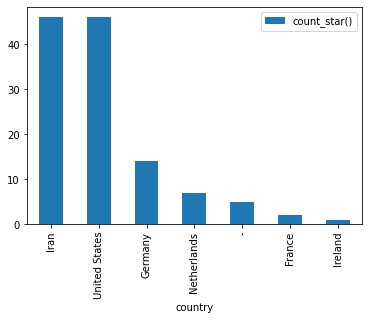

In [8]:
location_data = duckdb.query('''SELECT 
country, 
count(*) 
FROM 'data/2019/1/22/*/*.parquet' 
GROUP BY country
ORDER BY 2 desc''').df()
location_data.set_index('country', inplace=True)
location_data.plot.bar()

Or we could look at the status codes we've received across our data range.

<AxesSubplot:xlabel='status_code'>

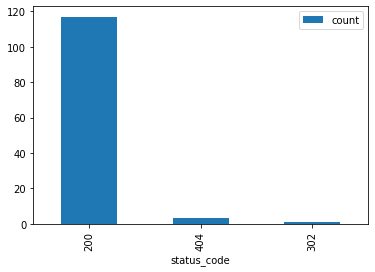

In [9]:
status_codes = duckdb.query('''SELECT 
status_code,
count(*) as count
FROM 'data/2019/1/22/*/*.parquet'
GROUP BY status_code
ORDER BY count desc
''').df()
status_codes.set_index('status_code', inplace=True)
status_codes.plot.bar()

And then isolate the ip address for each of the status codes that was not a 200 request to see if there are a common offenders.

In [10]:
non_200 = duckdb.query('''SELECT 
status_code,
ip,
count(*) as count
FROM 'data/2019/1/22/*/*.parquet'
WHERE status_code != 200
GROUP BY status_code, ip
ORDER BY count desc
''').df()
non_200

,status_code,ip,count
0,404,66.249.66.194,1
1,404,5.211.97.39,1
2,302,54.36.148.87,1
3,404,207.46.13.136,1


In [11]:
non_200_raw = duckdb.query('''SELECT 
*
FROM 'data/2019/1/22/*/*.parquet'
WHERE status_code != 200
''').df()
non_200_raw

,city,region,country,ip,1-,2-,event_time,request_url,status_code,3-,request_referrer,user_agent,4-
0,Ashburn,Virginia,United States,66.249.66.194,-,-,22/Jan/2019:03:56:23 +0330,GET /product/81900 HTTP/1.1,404,32278,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,-
1,Tehran,Tehran,Iran,5.211.97.39,-,-,22/Jan/2019:03:56:31 +0330,HEAD /amp_preconnect_polyfill_404_or_other_err...,404,0,https://www.zanbil.ir/m/browse/cooking-tools/%...,Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_2 like...,-
2,-,-,-,54.36.148.87,-,-,22/Jan/2019:03:56:34 +0330,GET /filter/p65%2Cv1%7C%D9%86%D9%82%D8%B1%D9%8...,302,0,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,-
3,Quincy,Washington,United States,207.46.13.136,-,-,22/Jan/2019:03:56:19 +0330,GET /product/14926 HTTP/1.1,404,33617,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,-


That is interesting. Let's look at who those might be?

In [14]:
from ipwhois import IPWhois
from pprint import pprint

for ip in non_200['ip'].to_list():
    obj = IPWhois(ip)
    results = obj.lookup_rdap(depth=1)
    print(results['asn_description'])
    

GOOGLE, US
MCCI-AS, IR
OVH, FR
MICROSOFT-CORP-MSN-AS-BLOCK, US


We won't dive any deeper than this at the moment as I think this demonstrates what you need to get started answering your relevant business questions with the Lightweight Data Stack.